In [1]:
from ClusteringCode import *
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.stats import ttest_ind

# Setting up data

In [4]:
cnxn = pymysql.connect(**CONN_INFO)

In [5]:
data = get_data(cnxn)
data = data[data.oid >= -21]

# The index gives the legislator
leg_scores_df = make_leg_scores(data)

# Running PCA

In [6]:
# Set each columns to have mean 0 std 1
X = preprocessing.scale(leg_scores_df)

pca = PCA(n_components=3)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Explained Variance

In [7]:
pca.explained_variance_ratio_

array([ 0.87729227,  0.04518477,  0.02218102])

With over 85% of the variance explained by the first PC, it's clear that we would like to retain just one Principle Component. <br>
<br>
Next we see the coefficients associated with each feature in PC 1. 

### Interpretation

In [8]:
org_info_df = get_org_info(data)
oid_to_name = pd.Series(data=org_info_df.name.values,
                        index=org_info_df.oid)

org_names = [oid_to_name[oid] for oid in leg_scores_df.columns]

for co, name in sorted(zip(pca.components_[0], org_names), 
                       key=lambda x: np.abs(x[0]), 
                       reverse=True):
    print(round(co, 2), '-->', name)

-0.24 --> California Labor Federation
-0.24 --> California Teachers Association
-0.24 --> American Federation of State, County and Municipal Employees
-0.24 --> Consumer Attorneys Of California
-0.24 --> California Immigrant Policy Center
-0.24 --> Western Center on Law and Poverty
-0.23 --> Sierra Club California
-0.23 --> American Civil Liberties Union of California
0.23 --> California Chamber of Commerce
0.23 --> California Manufacturers And Technology Association
0.23 --> California Farm Bureau Federation
0.23 --> Howard Jarvis Taxpayers Association
0.23 --> California Building Industry Association
-0.23 --> Children Now
-0.23 --> California Catholic Conference
-0.22 --> California Medical Association
-0.2 --> Disability Rights California
0.2 --> California District Attorneys Association
0.18 --> Association Of California Water Agencies
-0.14 --> California State Association Of Counties


It's obvious from the coefficients that the separation between legislators is based on their votes with partisan organizations. Liberal organization get a negative coefficient while conservative organizations get a positive coefficient. It is possible we might be able to get a second dimension out of PCA if we include a wider array of organizations. 

In [9]:
pca = PCA(n_components=1)
pca.fit(X)

prj_X = pca.transform(X)

# Agglomerative Clustering

## The Dendogram for Legislators
*This code was actually run in R studio for convenience*
<br><br>
clusters = hclust(dist(prj_X))
<br>
plot(clusters)

<img src="legislator_dendogram.png">

From the dendogram is is obvious that we should generate *4* clusters

In [10]:
model = AgglomerativeClustering(linkage = 'ward', 
                                n_clusters = 4)
model.fit(prj_X);

leg_scores_df['cluster'] = model.labels_

leg_scores_df = leg_scores_df.reset_index()
leg_scores_df.rename(columns={'index': 'pid'}, inplace=True)

leg_info_df = get_leg_info(data)
keep = list(leg_scores_df.columns) + ['party', 'district', 'house']

leg_scores_df = leg_scores_df.merge(leg_info_df, on='pid')[keep]


cluster_metrics_df = leg_scores_df.groupby('cluster').apply(group_metrics, 
                                                            org_info_df)

In [11]:
cluster_metrics_df

name,"American Federation of State, County and Municipal Employees",Western Center on Law and Poverty,California Medical Association,Disability Rights California,Consumer Attorneys Of California,American Civil Liberties Union of California,California Immigrant Policy Center,California Labor Federation,California Building Industry Association,Association Of California Water Agencies,...,Children Now,California District Attorneys Association,California State Association Of Counties,California Chamber of Commerce,Sierra Club California,California Teachers Association,assembly,dems,reps,senate
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.237669,0.295461,0.369244,0.484328,0.207276,0.191398,0.200965,0.106954,0.812423,0.658615,...,0.329524,0.723724,0.507771,0.877452,0.204676,0.141979,20,0,33,13
1,0.900493,0.897135,0.697810,0.677835,0.877244,0.668611,0.897738,0.891594,0.449597,0.574061,...,0.939361,0.615248,0.600528,0.414776,0.748692,0.891287,12,15,0,3
2,0.476041,0.550127,0.537443,0.621551,0.473268,0.402023,0.513124,0.317969,0.742031,0.693884,...,0.691893,0.665735,0.523433,0.773088,0.442284,0.424699,8,0,9,1
3,0.950767,0.987267,0.728902,0.740999,0.940766,0.801192,0.982147,0.978405,0.350529,0.511781,...,0.972584,0.370253,0.608551,0.239635,0.856914,0.966452,41,64,0,23


In [12]:
cluster_names = {0: 'conservative', 
                 1: 'moderate liberal', 
                 2: 'moderate conservative', 
                 3: 'liberal'}
leg_scores_df['cluster_name'] = leg_scores_df['cluster'].apply(lambda x: 
                                                               cluster_names[x])

# Generating the Maps

## Mapping for Senate

In [13]:
%%capture
s_m = make_base_map('Senate')

In [14]:
s_df_poly = create_poly_df(leg_scores_df, s_m, 'Senate')

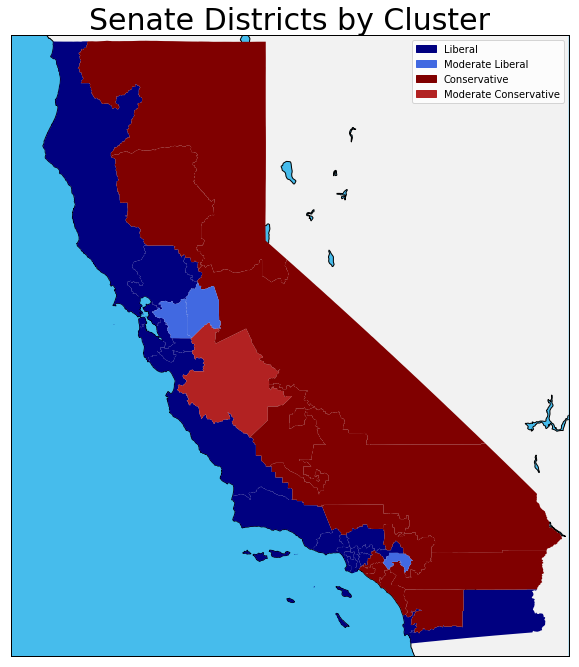

In [15]:
plot_map(s_df_poly, s_m)
plt.title('Senate Districts by Cluster', fontsize=30)

## Mapping for assembly

In [16]:
%%capture
a_m = make_base_map('Assembly')

In [17]:
a_df_poly = create_poly_df(leg_scores_df, a_m, 'Assembly')

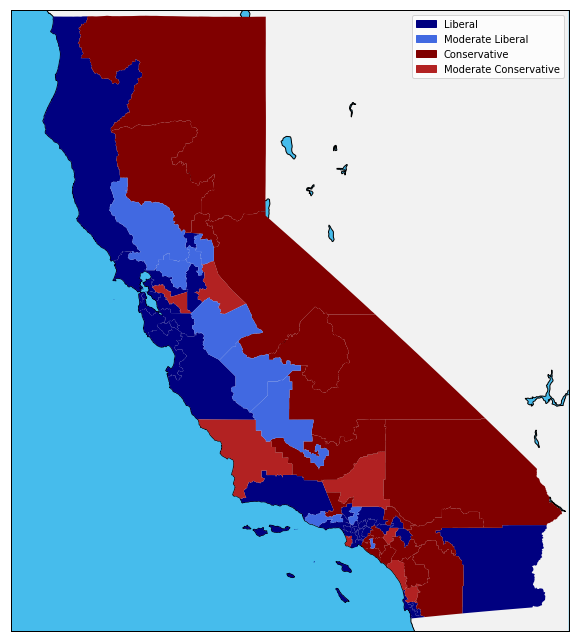

In [18]:
plot_map(a_df_poly, a_m)

# T Tests

In [19]:
from itertools import combinations

In [20]:
import statsmodels.stats.api as sms

In [21]:
oids = org_info_df.oid.unique()

In [22]:
cluster_names.values()

dict_values(['conservative', 'moderate liberal', 'moderate conservative', 'liberal'])

In [53]:
out = []
ci_out = []
for c1, c2 in combinations(cluster_names.values(), 2):
    x1 = leg_scores_df[leg_scores_df.cluster_name == c1].loc[:, oids]
    x2 = leg_scores_df[leg_scores_df.cluster_name == c2].loc[:, oids]

    results = ttest_ind(x1, x2)

    results_df = pd.DataFrame({'oid': oids, 
                               't_stat': results[0], 
                               'p_value': results[1]})
    results_df = results_df.merge(org_info_df, 
                                  on='oid')[list(results_df.columns) + ['name']]
    
    mean_diff = x1.mean() - x2.mean()
    cm = sms.CompareMeans(sms.DescrStatsW(x1), sms.DescrStatsW(x2))
    ci = cm.tconfint_diff(usevar='unequal')
    ci_l = ci[0]
    ci_u = ci[1]
    
    results_df['ci_lower'] = ci_l
    results_df['ci_upper'] = ci_u
    
    results_df['mean_diff'] = mean_diff.values
    
    results_df = results_df[results_df.p_value > .05]

    
#     ci_df = pd.DataFrame({'oid': oids,
#                           'mean_diff': mean_diff,
#                           'lower': ci_l,
#                           'upper': ci_u})
#     ci_df = ci_df.merge(org_info_df, 
#                                   on='oid')[list(ci_df.columns) + ['name']]
#     ci_out.append(ci_df)

    print(c1, c2)
    out.append(results_df)

conservative moderate liberal
conservative moderate conservative
conservative liberal
moderate liberal moderate conservative
moderate liberal liberal
moderate conservative liberal


Displayed below is the output of the confidence intervals and the T tests comparings the different clusters alignments relative to the organizations. Only *non-significant* differences are included. Ie we want to see where the groups clusters are most similary. An empty dataframe means that all differences were signficant. 

### conservative vs. moderate liberal

In [62]:
out[0].sort_values('mean_diff')

,oid,p_value,t_stat,name,ci_lower,ci_upper,mean_diff


### conservative vs moderate conservative

In [63]:
out[1].sort_values('mean_diff')

,oid,p_value,t_stat,name,ci_lower,ci_upper,mean_diff
9,-12,0.144744,-1.487425,Association Of California Water Agencies,-0.089857,0.019318,-0.035269
16,-5,0.503262,-0.675473,California State Association Of Counties,-0.066099,0.034774,-0.015663
11,-10,0.076372,1.819199,California Farm Bureau Federation,-0.014881,0.097703,0.041411
12,-9,0.290460,1.071291,Howard Jarvis Taxpayers Association,-0.085850,0.173628,0.043889


### conservative vs liberal

In [64]:
out[2].sort_values('mean_diff')

,oid,p_value,t_stat,name,ci_lower,ci_upper,mean_diff


### moderate liberal vs moderate conservative

In [65]:
out[3].sort_values('mean_diff')

,oid,p_value,t_stat,name,ci_lower,ci_upper,mean_diff
15,-6,0.176124,-1.397752,California District Attorneys Association,-0.121513,0.020539,-0.050487
3,-18,0.152422,1.482385,Disability Rights California,-0.040438,0.153006,0.056284


### moderate liberal vs liberal

In [66]:
out[4].sort_values('mean_diff')

,oid,p_value,t_stat,name,ci_lower,ci_upper,mean_diff
2,-19,0.055458,-1.944737,California Medical Association,-0.084875,0.022691,-0.031092
16,-5,0.646809,-0.460005,California State Association Of Counties,-0.048495,0.032449,-0.008023


### moderate conservative vs liberal

In [67]:
out[5].sort_values('mean_diff')

,oid,p_value,t_stat,name,ci_lower,ci_upper,mean_diff


## Clustering for Organizations
This is just done for fun. Organizations cluster nicely. 

In [76]:
q = """SELECT p.first, p.last, o.name, s.*
       FROM Person p 
           JOIN LegAlignmentScores s 
               ON p.pid = s.pid
           JOIN OrgConcept o 
               on s.oid = o.oid
       WHERE s.no_unanimous = 1
           and s.no_resolutions = 1
           and s.no_abstain_votes = 1
           and session_year = '2015'
    """
data = pd.read_sql(q, cnxn)

In [77]:
df_lst = []
for g, g_df in data.groupby(['oid']):
    df = g_df[['pid', 'score']].transpose()
    df.columns = df.loc['pid']
    df.drop('pid', inplace=True)
    df.index = [g]
    df_lst.append(df)
data = pd.concat(df_lst)

## The Dendogram for Organizations
*This code was actually run in R studio for convenience*
<br><br>
clusters = hclust(dist(data))
<br>
plot(clusters)

<img src="organization_dendogram.png">

In [78]:
model = AgglomerativeClustering(linkage = 'ward', 
                                n_clusters = 4)

In [79]:
model.fit(data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=4,
            pooling_func=<function mean at 0x000001D7F5754598>)

In [80]:
data['cluster'] = model.labels_

In [81]:
data = data.reset_index()
data.rename(columns={'index': 'oid'}, inplace=True)
keep = ['oid', 'cluster', 'name']
data = data.merge(org_info_df, on='oid')[keep]

## The clusters

In [82]:
data[data.cluster == 0]

pid,oid,cluster,name
8,-13,0,California Building Industry Association
11,-10,0,California Farm Bureau Federation
12,-9,0,Howard Jarvis Taxpayers Association
13,-8,0,California Manufacturers And Technology Associ...
15,-6,0,California District Attorneys Association
17,-4,0,California Chamber of Commerce


In [83]:
data[data.cluster == 1]

pid,oid,cluster,name
2,-19,1,California Medical Association
3,-18,1,Disability Rights California
5,-16,1,American Civil Liberties Union of California
10,-11,1,California Catholic Conference
18,-3,1,Sierra Club California


In [84]:
data[data.cluster == 2]

pid,oid,cluster,name
0,-21,2,"American Federation of State, County and Munic..."
1,-20,2,Western Center on Law and Poverty
4,-17,2,Consumer Attorneys Of California
6,-15,2,California Immigrant Policy Center
7,-14,2,California Labor Federation
14,-7,2,Children Now
19,-1,2,California Teachers Association


In [85]:
data[data.cluster == 3]

pid,oid,cluster,name
9,-12,3,Association Of California Water Agencies
16,-5,3,California State Association Of Counties
